<a href="https://colab.research.google.com/github/VishalTyagi09/My-first-Ml-Models/blob/master/FinanceProject_StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mpl_finance

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader.data as web

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
style.use('ggplot')
start = dt.datetime(2011,1,1)
end = dt.datetime(2020,6,15)
df = web.DataReader('RELIANCE.NS','yahoo',start,end)

In [ ]:
df.to_csv('Reliance.csv')

In [ ]:
df=pd.read_csv('Reliance.csv',parse_dates= True,index_col=0)

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,533.250000,526.299988,532.500000,527.799988,4759676.0,456.721252
2011-01-04,539.950012,528.650024,530.000000,538.549988,10067662.0,466.023590
2011-01-05,545.000000,535.000000,540.000000,537.900024,11860378.0,465.461151
2011-01-06,545.700012,537.275024,539.000000,542.799988,9949394.0,469.701233
2011-01-07,543.875000,529.000000,540.650024,532.700012,8171898.0,460.961426


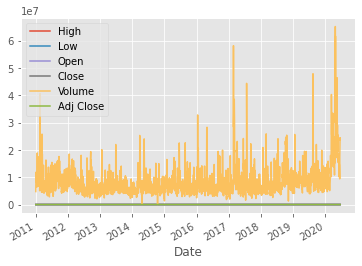

In [ ]:
df.plot()
plt.show()

In [ ]:
df['100ma']= df['Adj Close'].rolling(window = 100,min_periods=0).mean()

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,100ma
Date,,,,,,,
2011-01-03,533.250000,526.299988,532.500000,527.799988,4759676.0,456.721252,456.721252
2011-01-04,539.950012,528.650024,530.000000,538.549988,10067662.0,466.023590,461.372421
2011-01-05,545.000000,535.000000,540.000000,537.900024,11860378.0,465.461151,462.735331
2011-01-06,545.700012,537.275024,539.000000,542.799988,9949394.0,469.701233,464.476807
2011-01-07,543.875000,529.000000,540.650024,532.700012,8171898.0,460.961426,463.773730


In [ ]:
df_ohlcc= df['Adj Close'].resample('10D').ohlc()
df_volume= df['Volume'].resample('10D').sum()
df_ohlcc.reset_index(inplace=True)
df_ohlcc.head()

,Date,open,high,low,close
0,2011-01-03,456.721252,469.701233,438.614258,445.991272
1,2011-01-13,439.306519,439.306519,419.620239,426.953918
2,2011-01-23,420.377380,420.377380,387.451630,387.451630
3,2011-02-02,398.614410,408.392670,389.247162,393.703613
4,2011-02-12,395.802063,413.779297,395.802063,413.779297


<BarContainer object of 2323 artists>

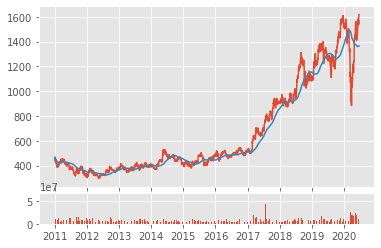

In [ ]:
ax1 =plt.subplot2grid((6,1),(0,0),rowspan = 5,colspan=1)
ax2 =plt.subplot2grid((6,1),(5,0),rowspan = 5,colspan=1,sharex = ax1)
ax1.plot(df.index,df['Adj Close'])
ax1.plot(df.index,df['100ma'])
ax2.bar(df.index,df['Volume'])

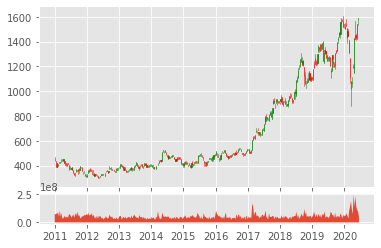

In [ ]:
df_ohlcc['Date']=df_ohlcc['Date'].map(mdates.date2num)
ax1 =plt.subplot2grid((6,1),(0,0),rowspan = 5,colspan=1)
ax2 =plt.subplot2grid((6,1),(5,0),rowspan = 5,colspan=1,sharex = ax1)
ax1.xaxis_date()
candlestick_ohlc(ax1,df_ohlcc.values,width=2,colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num),df_volume.values,0)

In [ ]:
import bs4 as bs
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web 
import pickle
import requests
from sklearn import svm,neighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
style.use('ggplot')

In [ ]:
def save_sp500_tickers():
  resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
  soup = bs.BeautifulSoup(resp.text,'lxml')
  table = soup.find('table',{'class':'wikitable sortable'})
  tickers = []
  for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text.replace('\n','')
    if "." in ticker:
            ticker = ticker.replace('.','-')
            print('ticker replaced to', ticker) 
    tickers.append(ticker)

  with open("sp500tickers.pickle","wb") as f:
    pickle.dump(tickers,f)
  return tickers
save_sp500_tickers()



In [ ]:
def get_data_from_yahoo(reload_sp500 = False):
  if reload_sp500:
    tickers = save_sp500_tickers()
  else:
    with open("sp500tickers.pickle","rb") as f:
      tickers = pickle.load(f)

  if not os.path.exists('stocks_dfs'):
    os.makedirs('stocks_dfs')

  start = dt.datetime(2008,1,1)
  end = dt.datetime(2020,6,18)

  for ticker in tickers:
    print(ticker)
    if not os.path.exists('stocks_dfs/{}.csv'.format(ticker)):
      df = web.DataReader(ticker,'yahoo',start, end)
      df.to_csv('stocks_dfs/{}.csv'.format(ticker))
    else:
      print('Already have {}'.format(ticker))
get_data_from_yahoo()    


In [ ]:
def compile_data():
  with open("sp500tickers.pickle","rb") as f:
    tickers = pickle.load(f)

  main_df = pd.DataFrame()

  for count,ticker in enumerate(tickers):
    df = pd.read_csv('stocks_dfs/{}.csv'.format(ticker.replace('.', '-')))
    df.set_index('Date',inplace=True)

    df.rename(columns = {'Adj Close':ticker},inplace=True)
    df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)

    if main_df.empty:
      main_df = df
    else:
       main_df= main_df.join(df,how = 'outer')

    if count % 10 ==0:
      print(count)

  print(main_df.head())
  main_df.to_csv(" sp500_joined_closes.csv")

compile_data()    




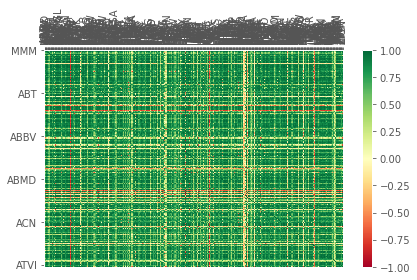

In [ ]:
def visualize_data():
  df = pd.read_csv('/content/ sp500_joined_closes.csv')
  df_corr = df.corr()
  
  data = df_corr.values
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)

  heatmap = ax.pcolor(data,cmap=plt.cm.RdYlGn)
  fig.colorbar(heatmap)
  ax.set_xticks(np.arange(data.shape[0]) + 0.5,minor= False)
  ax.set_xticks(np.arange(data.shape[1]) + 0.5,minor= False)
  ax.invert_yaxis()
  ax.xaxis.tick_top()

  columns_lables = df_corr.columns
  row_labels = df_corr.index

  ax.set_xticklabels(columns_lables)
  ax.set_yticklabels(row_labels)
  plt.xticks(rotation=90)
  heatmap.set_clim(-1,1)
  plt.tight_layout()
  plt.show()


visualize_data()  

In [ ]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv('/content/ sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0, inplace=True)
    return tickers, df

In [ ]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > 0.2:
            return 1
        if col < -0.2:
            return -1
    return 0

In [ ]:
def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)

    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)]))

    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:', Counter(str_vals))

    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)

    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    return X, y, df

In [ ]:
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

    clf = neighbors.KNeighborsClassifier()
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print('accuracy:',confidence)
    predictions = clf.predict(X_test)
    print('predicted class counts:',Counter(predictions))

    return confidence

do_ml('BAC')    

Data spread: Counter({'0': 2978, '1': 84, '-1': 76})
accuracy: 0.9554140127388535
predicted class counts: Counter({0: 777, -1: 8})


0.9554140127388535